# Project

## Download Data

In [1]:
import urllib
import json
import pandas as pd
from bd_addons.interpro_data import *
from bd_addons.HmmPy import *
from bd_addons.metrics import *
from Bio import SearchIO, SeqIO

url = "https://www.ebi.ac.uk/interpro/api/protein/reviewed/entry/pfam/pf03060?format=json"

In [2]:
our_domain = 'KTFEVRYPIIQAPMAGASTLELAATVTRLGGIGSIPMGSLSEKCDAIETQLENFDELVGDSGRIVNLNFFAHKEPRSGRADVNEEWLKKYDKIYGKAGIEFDKKELKLLYPSFRSIVDPQHPTVRLLKNLKPKIVSFHFGLPHEAVIESLQASDIKIFVTVTNLQEFQQAYESKLDGVVLQGWEAGGHRGNFKANDVEDGQLKTLDLVSTIVDYIDSASISNPPFIIAAGGIHDDESIKELLQFNIAAVQLGTVWLPSSQATISPEHLKMFQSPKSDTMMTAAISGRNLRTISTPFLRDLHQSSPLASIPDYPLPYDSFKSLANDAKQSGKGPQYSAFLAGSNYHKSWKDTRSTEEIFSILVQ'
print(len(our_domain))
print(our_domain[9:372])

363
IQAPMAGASTLELAATVTRLGGIGSIPMGSLSEKCDAIETQLENFDELVGDSGRIVNLNFFAHKEPRSGRADVNEEWLKKYDKIYGKAGIEFDKKELKLLYPSFRSIVDPQHPTVRLLKNLKPKIVSFHFGLPHEAVIESLQASDIKIFVTVTNLQEFQQAYESKLDGVVLQGWEAGGHRGNFKANDVEDGQLKTLDLVSTIVDYIDSASISNPPFIIAAGGIHDDESIKELLQFNIAAVQLGTVWLPSSQATISPEHLKMFQSPKSDTMMTAAISGRNLRTISTPFLRDLHQSSPLASIPDYPLPYDSFKSLANDAKQSGKGPQYSAFLAGSNYHKSWKDTRSTEEIFSILVQ


In [3]:
metadata, entries, gt = get_data(url, 1)
print(gt.shape)
gt.head(10)

(23, 4)


,accession,start,end,length
0,A5IR97,5,345,355
1,A6QFD2,5,345,355
2,A6U025,5,345,355
3,A8Z1H7,5,345,355
4,B2TEK6,10,350,366
5,D0V3Y4,5,344,349
6,O05413,3,343,347
7,O06179,23,361,375
8,O34787,321,590,767
9,P47177,29,388,404


Here we download with the InterPro APIs our ground truth for our domain. We get 23 sequences in the Interpro database that match our PFAM family.

# 1 - Model Creation
To build our models, our first task was to retrieve sequence homologues with our domain sequence.
To do this, we performed both searches in reviewed and unreviewed databases, and we kept the significant hits (E-value < 0.01). We then made some attempts on varying the number of significant hits to see if that could improve the performances of the models.

- In Swiss-Prot (annotated) we found 14 significant hits; (Call those try_1)
- In Uniref90 we found 250 significant hits. (try_3)
- From the 250 significant hits from Uniref90, we tried to take just the first 100 (try_4)

For each of those sets of retrieved hits, we performed a multiple sequence alignment (MSA). To do this, made the MSAs using three different algorithms: T-Coffee, Muscle and Clustal-Omega. Comparing the results we found that T-Coffee is generally better.

For each of those MSAs, we built a PSSM (Position-Specific Scoring Matrix) and a HMM (Hidden Markov Model). We then performed a PSI-BLAST search and HMM-Search using respectively our PSSM and our HMM as inputs. To do this we used the command line versions of *blast+* and *hmmer*; the bash scripts that manage the model creation can be found in data\PSSMs\pssm+psiblast.sh  data\HMMSs\generate_hmms.sh 


## Evaluate Ability of Matching sequences
Once we got the hits from our models, using PSI-BLAST and HMMER searches, we parsed the output files inside tables, which contain, for each hit:
- The Protein UniProt ID;
- The relative E-value of the hit;
- Where the model predicted the domain to begin;
- Where the model predicted the domain to end;

At this point, to evaluate the ability of our model to find the right sequences, we had to check how many sequences the model:
- Correctly predicted to contain the domain (TP);
- Wrongly predicted to contain the domain (FP);
- Correctly predicted **not** to contain the domain (TN);
- Wrongly predicted **not** to contain the domain (FN).

Note that, technically, we should consider as True Negatives also all the proteins in SwissProt that our model correctly predicted not to have the domain (that is, all the proteins that our model didn't find, and that actually don't have the domain). While this is true, in this way any model would have an extremely high number of True Negatives, since the number of significant hits of a model is always much smaller than the size of uniprot (around 560.000 sequences). This statistic would not help us in any way to assess the ability of our models, and would significantly slow our computation times, so we decided not to compute that quantity.
Below we report our results with some of the better performing models.

In [4]:
# the last 3 parameters are thresholds for the E-values. Our models will consider significant only sequences that have e-values under that threshold.

# - the first one is the Sequence E-Value for HMMs;
# - the second one is the Domain independent E-value for HMMs;
# - the third one is the E-Value returned by the Psi-Blast searches made with our PSSM models.

metrics_df, parsed_tblouts, parsed_domtblouts, parsed_psiblast = metrics_8(gt, 0.01, 0.01, 0.01)
metrics_df

,n_hits,accuracy,precision,recall,specificity,balanced_accuracy,mcc,f1_score
hmmsearch_out_C_1_denoised1_swissprot.domtblout,379.0,0.999369,0.060686,1.000000,0.999369,0.999684,0.246268,0.114428
hmmsearch_out_C_1_swissprot.domtblout,385.0,0.999358,0.059740,1.000000,0.999358,0.999679,0.244340,0.112745
hmmsearch_out_C_3_denoised1_uniref90.domtblout,310.0,0.999491,0.074194,1.000000,0.999491,0.999746,0.272316,0.138138
hmmsearch_out_C_3_uniref90.domtblout,309.0,0.999493,0.074434,1.000000,0.999493,0.999746,0.272756,0.138554
hmmsearch_out_C_4_denoised1_uniref90.domtblout,218.0,0.999651,0.100917,0.956522,0.999652,0.978087,0.310633,0.182573
hmmsearch_out_C_4_uniref90.domtblout,229.0,0.999631,0.096070,0.956522,0.999633,0.978077,0.303077,0.174603
HMM_reference_search.domtblout,694.0,0.998810,0.033141,1.000000,0.998810,0.999405,0.181939,0.064156
hmmsearch_out_M_1.domtblout,333.0,0.999450,0.069069,1.000000,0.999450,0.999725,0.262738,0.129213
hmmsearch_out_M_4_denoised1_uniref90.domtblout,212.0,0.999661,0.103774,0.956522,0.999663,0.978092,0.315000,0.187234
hmmsearch_out_M_4_uniref90.domtblout,224.0,0.999640,0.098214,0.956522,0.999642,0.978082,0.306443,0.178138


Since we have an highly unbalanced dataset, some of those metrics will be useless to us. We restrict just on the useful metrics, that in this case are precision, MCC and F1-Score.
Maybe the most important in our case is precision, since we found that our models thend to have almost perfect recall, but bad precision. So we sort the data by precision to see the best models.

In [5]:
metrics_df_useful = metrics_df.loc[:,('n_hits','precision','recall', 'mcc','f1_score')]
metrics_df_useful.sort_values(by='precision', axis=0, ascending=False).head(5)

,n_hits,precision,recall,mcc,f1_score
out_psiblast_M_4_uniref90_1iterations.xml,81.0,0.271605,0.956522,0.509672,0.423077
out_psiblast_M_4_denoised1_uniref90_1iterations.xml,88.0,0.250000,0.956522,0.488978,0.396396
out_psiblast_M_3_uniref90_1iterations.xml,121.0,0.181818,0.956522,0.416989,0.305556
out_psiblast_C_1_swissprot_1iterations.xml,124.0,0.177419,0.956522,0.411912,0.299320
out_psiblast_C_1_denoised1_swissprot_1iterations.xml,157.0,0.140127,0.956522,0.366060,0.244444


We see a high number of hits, which bring our precision down, but the recall is always high, which suggests us that the model is finding almost all the ground truth proteins, but also finds some other proteins that are negative.
We try to plce a even lower threshold on the E-value to see if the performances are better.

In [23]:
metrics_df2, parsed_tblouts2, parsed_domtblouts2, parsed_psiblast2 = metrics_8(gt, 0.001, 0.001, 0.001)

In [24]:
metrics_df2
metrics_df2_useful = metrics_df2.loc[:,('n_hits','precision','recall', 'mcc','f1_score')]
summary8 = metrics_df2_useful.sort_values(by='precision', axis=0, ascending=False).head(5)
summary8

,n_hits,precision,recall,mcc,f1_score
out_psiblast_M_4_denoised1_uniref90_1iterations.xml,51.0,0.431373,0.956522,0.642334,0.594595
out_psiblast_M_4_uniref90_1iterations.xml,53.0,0.415094,0.956522,0.630097,0.578947
out_psiblast_M_3_uniref90_1iterations.xml,67.0,0.328358,0.956522,0.560405,0.488889
out_psiblast_O_1.xml,79.0,0.278481,0.956522,0.516085,0.431373
hmmsearch_out_M_4_denoised1_uniref90.domtblout,79.0,0.278481,0.956522,0.516085,0.431373


## Plotting Metrics

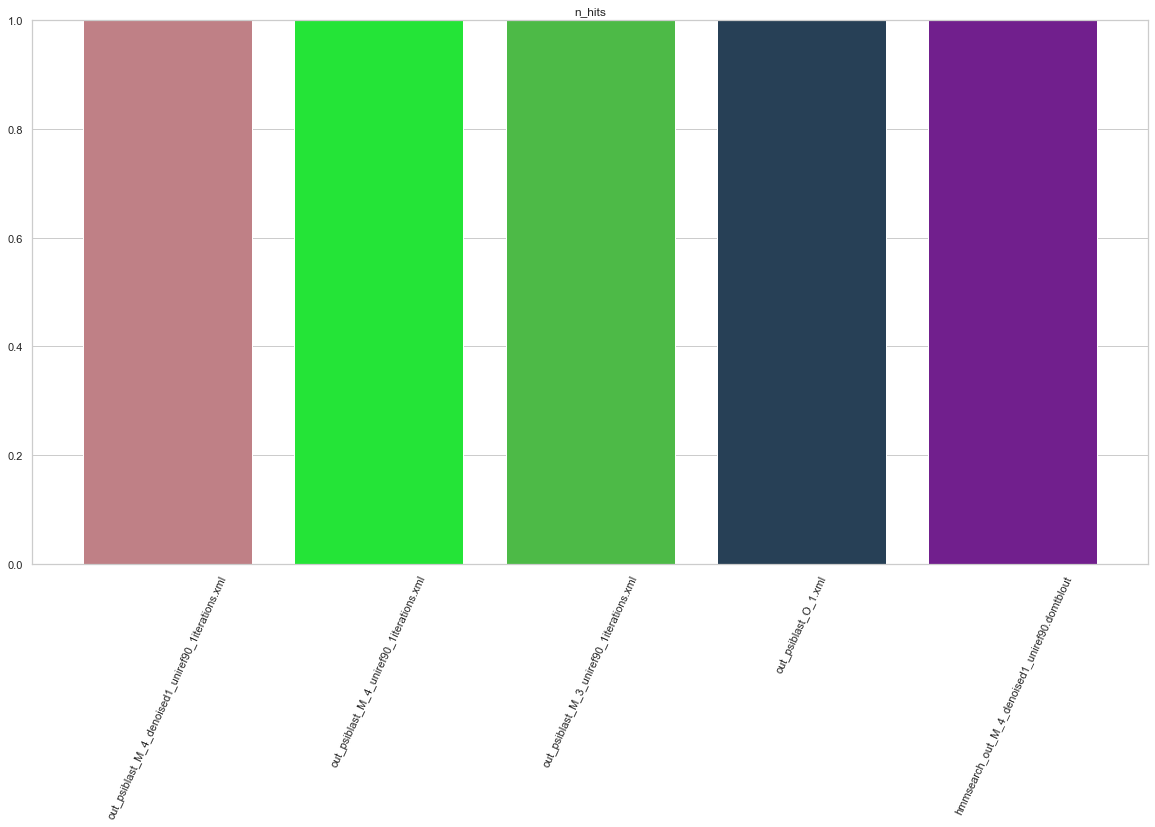

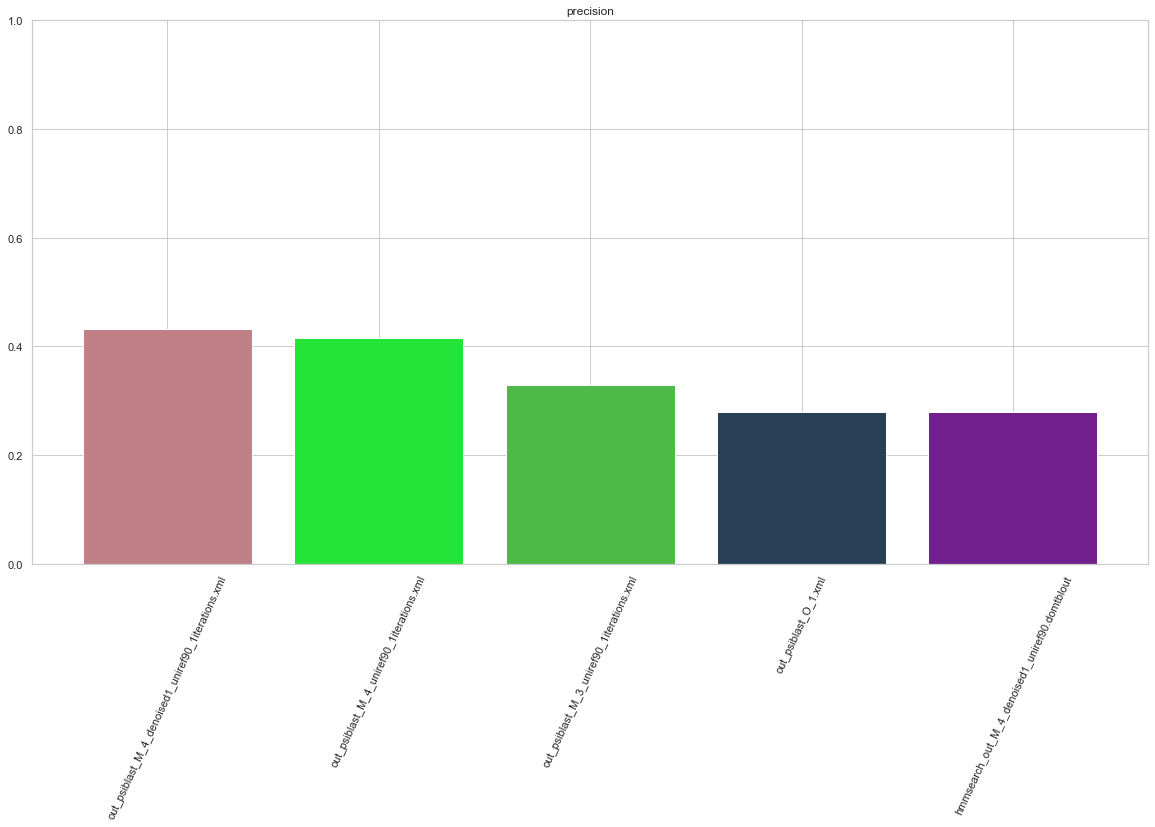

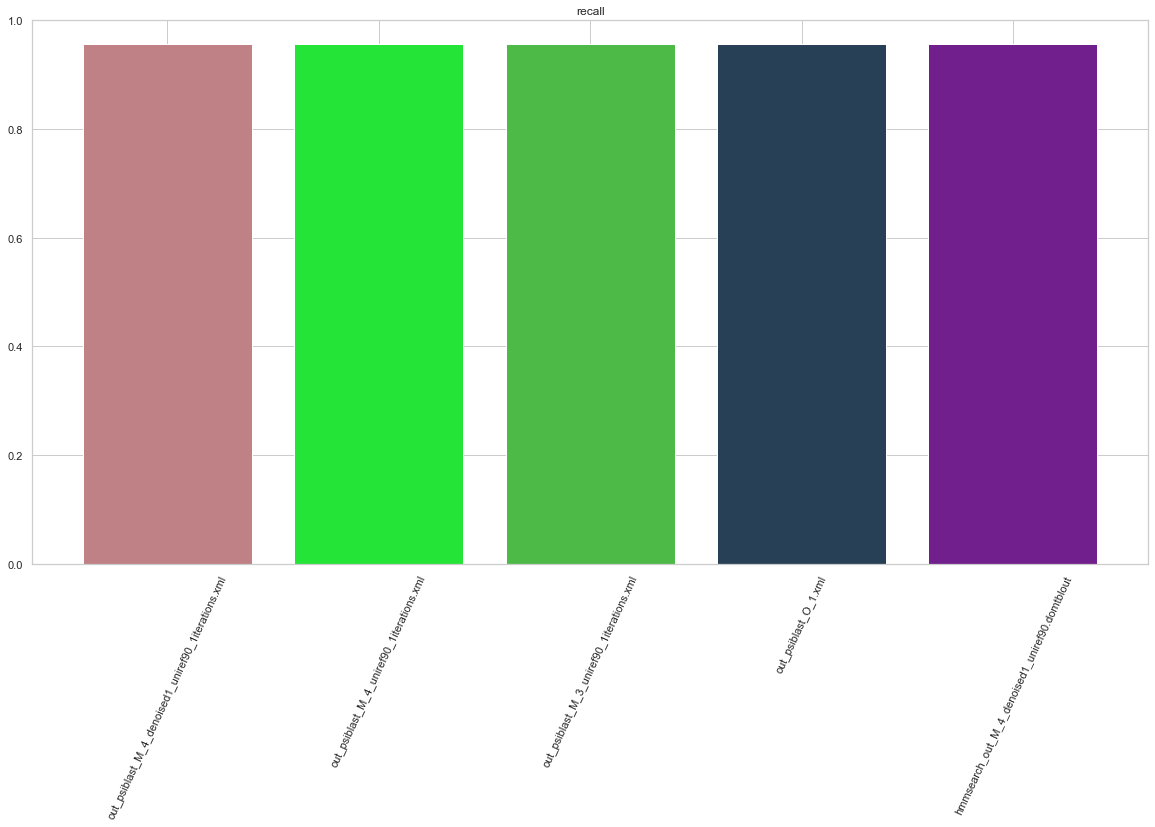

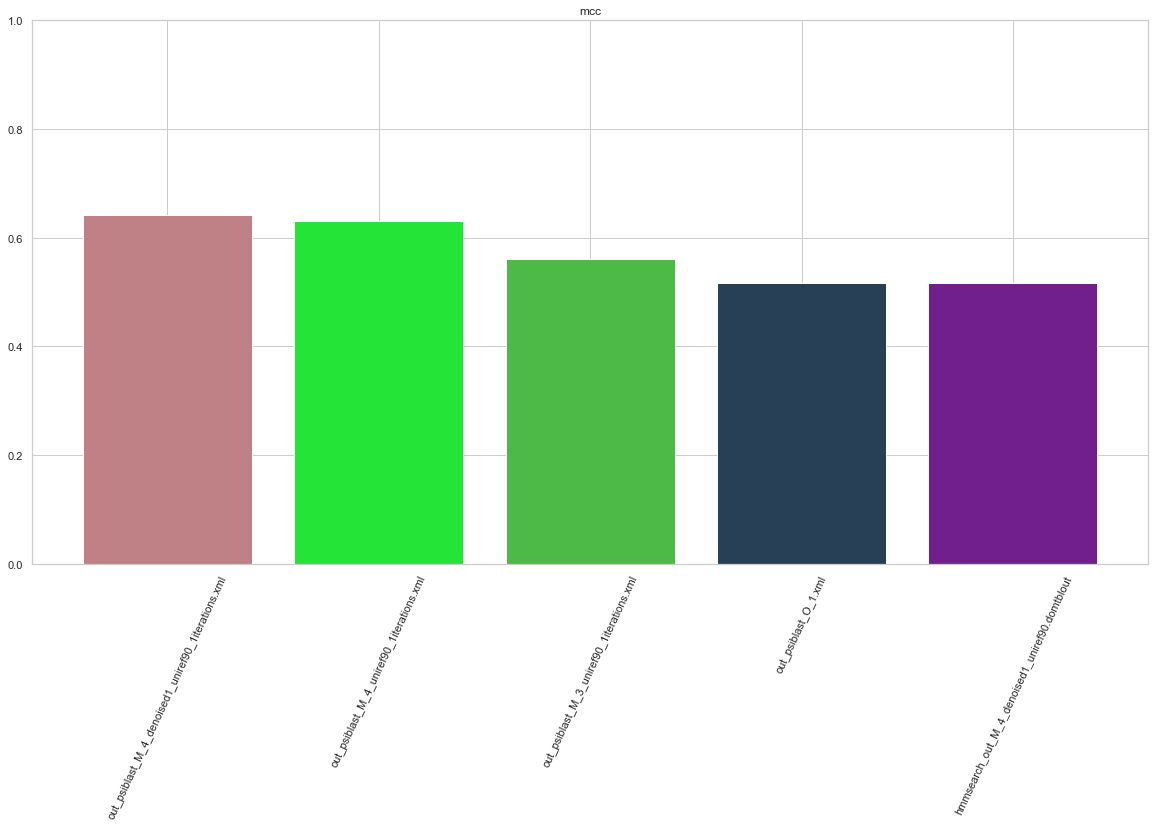

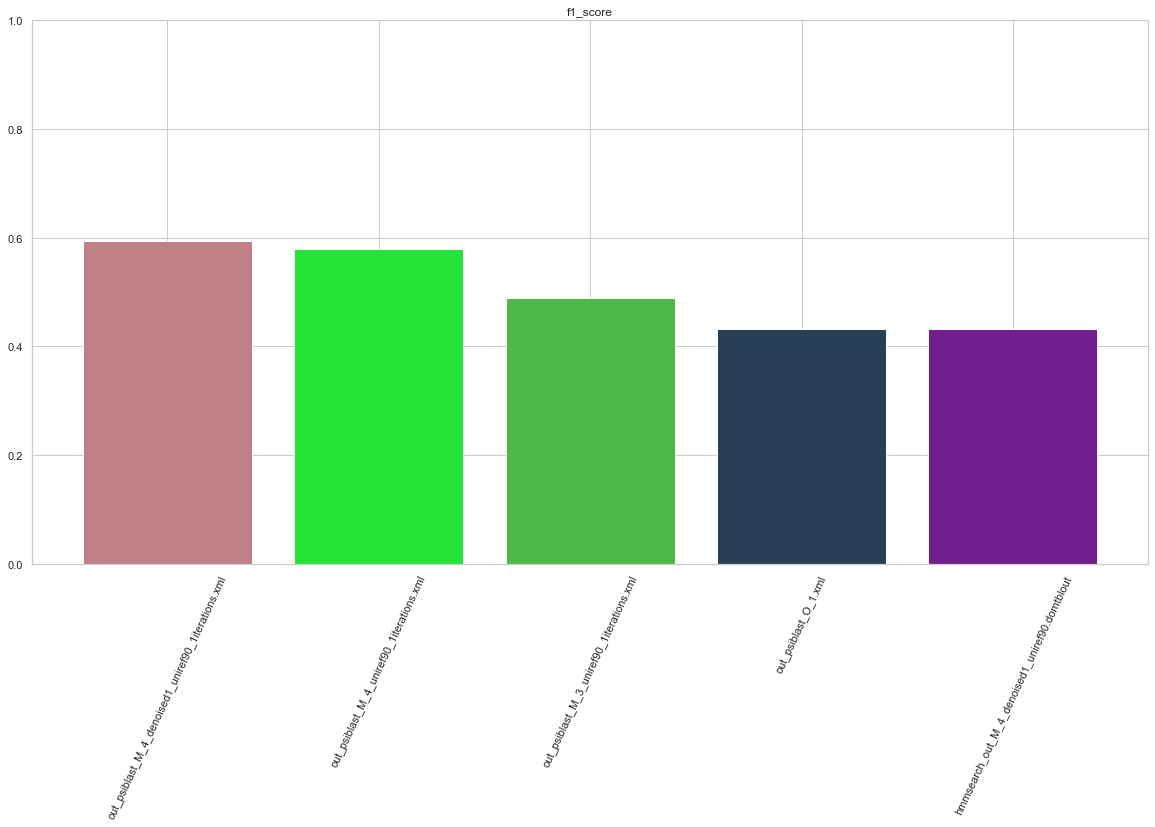

In [26]:
plot_metrics(summary8)

# 9 - Evaluate the ability of matching domain positions
Here we want to evaluate how good our model is at estimating domain positions inside the found proteins.

In [9]:
metrics_df, conf_df = metrics_9(parsed_domtblouts, parsed_psiblast, gt, 0.01, 0.01, 0.01)
metrics_df

,accuracy,precision,recall,specificity,balanced_accuracy,mcc,f1_score
hmmsearch_out_C_1_denoised1_swissprot.domtblout,0.837850,0.259392,0.987158,0.828780,0.907969,0.459217,0.410831
hmmsearch_out_C_1_swissprot.domtblout,0.838639,0.256295,0.997641,0.829262,0.913451,0.460209,0.407821
hmmsearch_out_C_3_denoised1_uniref90.domtblout,0.856991,0.321304,0.989385,0.847319,0.918352,0.517756,0.485078
hmmsearch_out_C_3_uniref90.domtblout,0.854959,0.319944,0.993710,0.844761,0.919235,0.517499,0.484042
hmmsearch_out_C_4_denoised1_uniref90.domtblout,0.855613,0.397667,0.951514,0.845321,0.898417,0.558569,0.560912
hmmsearch_out_C_4_uniref90.domtblout,0.852901,0.377804,0.960031,0.842209,0.901120,0.547091,0.542225
HMM_reference_search.domtblout,0.747295,0.116506,1.000000,0.738583,0.869292,0.293341,0.208697
hmmsearch_out_M_1.domtblout,0.841171,0.291431,0.973398,0.831772,0.902585,0.482520,0.448564
hmmsearch_out_M_4_denoised1_uniref90.domtblout,0.857504,0.404933,0.940244,0.848427,0.894336,0.559743,0.566075
hmmsearch_out_M_4_uniref90.domtblout,0.856417,0.386351,0.944437,0.847467,0.895952,0.548369,0.548374


In [11]:
metrics_df_useful = metrics_df.loc[:,('precision','recall', 'mcc','f1_score')]
metrics_df_useful.sort_values(by='precision', axis=0, ascending=False).head(5)

,precision,recall,mcc,f1_score
out_psiblast_M_4_uniref90_1iterations.xml,0.586668,0.954921,0.649996,0.726810
out_psiblast_M_4_denoised1_uniref90_1iterations.xml,0.569128,0.949417,0.639829,0.711655
out_psiblast_M_3_uniref90_1iterations.xml,0.467906,0.949548,0.580736,0.626898
hmmsearch_out_M_4_denoised1_uniref90.domtblout,0.404933,0.940244,0.559743,0.566075
hmmsearch_out_C_4_denoised1_uniref90.domtblout,0.397667,0.951514,0.558569,0.560912


In [12]:
metrics_df2, conf_df2 = metrics_9(parsed_domtblouts, parsed_psiblast, gt, 0.001, 0.001, 0.001)

In [16]:
metrics_df2
metrics_df2_useful = metrics_df2.loc[:,('precision','recall', 'mcc','f1_score')]
summary = metrics_df2_useful.sort_values(by='precision', axis=0, ascending=False).head(5)
summary

,precision,recall,mcc,f1_score
out_psiblast_M_4_denoised1_uniref90_1iterations.xml,0.722045,0.949417,0.701311,0.820266
out_psiblast_M_4_uniref90_1iterations.xml,0.696388,0.954921,0.684805,0.805416
out_psiblast_M_3_uniref90_1iterations.xml,0.639203,0.949548,0.661792,0.764064
out_psiblast_O_3_uniref90_1iterations.xml,0.519740,0.962652,0.624209,0.675029
out_psiblast_C_3_denoised1_uniref90_1iterations.xml,0.485984,0.956493,0.605685,0.644503


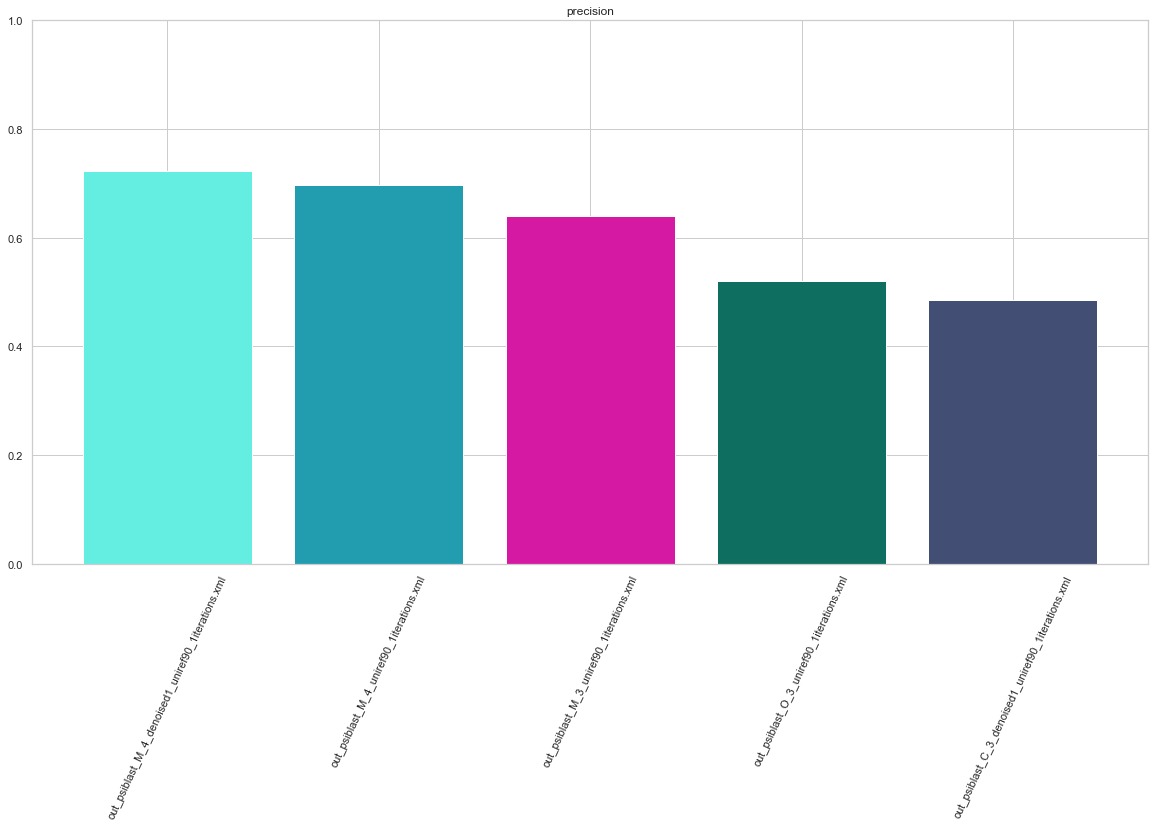

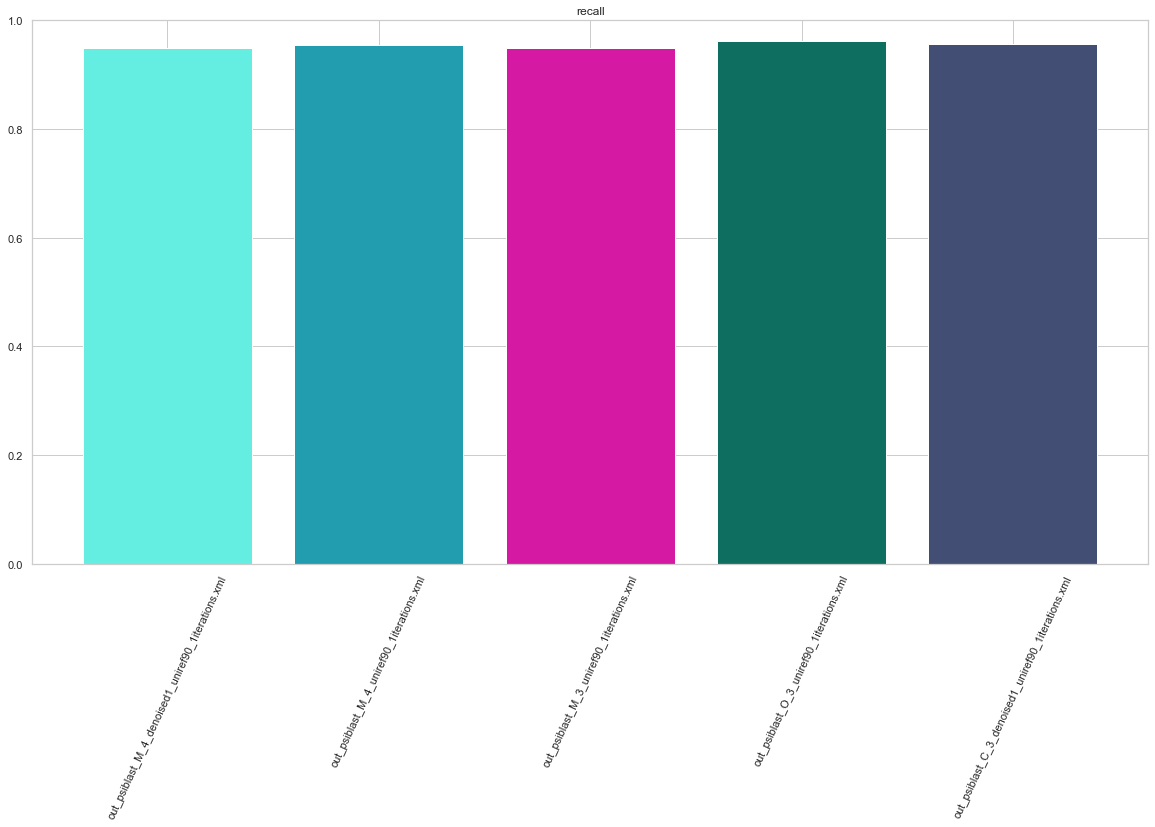

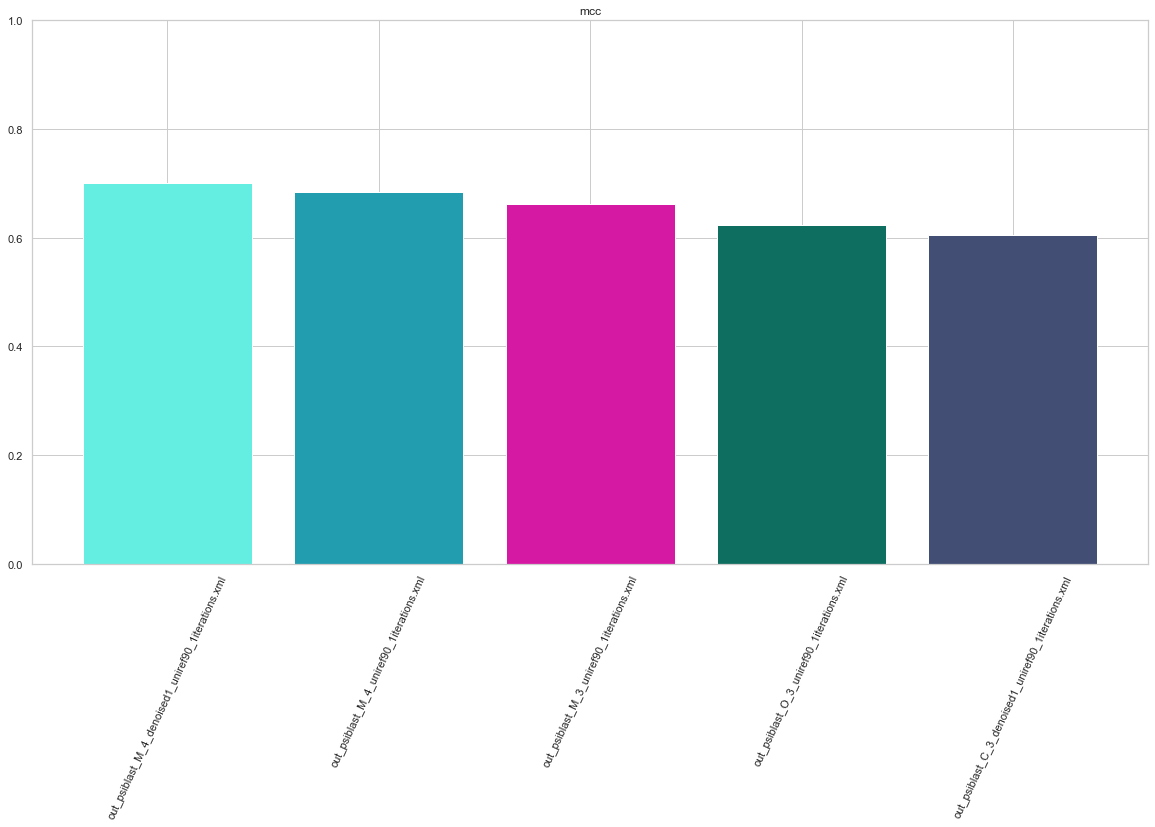

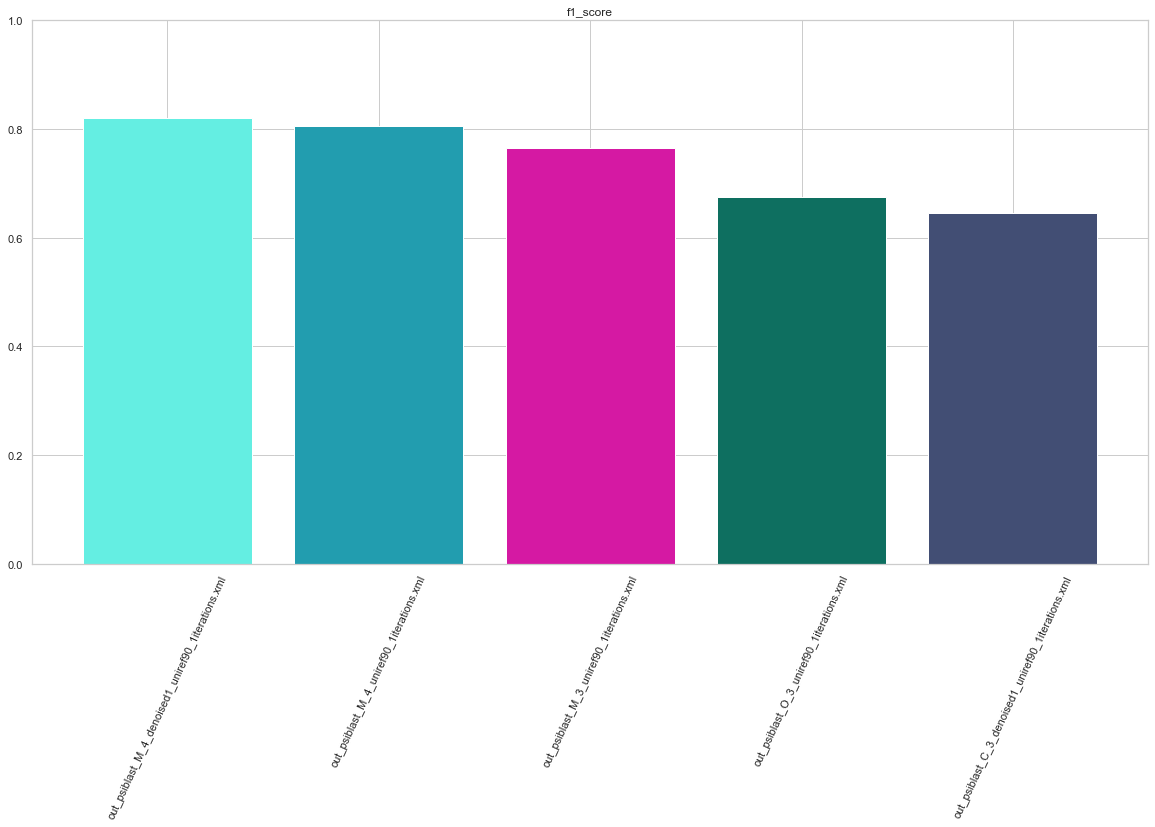

In [20]:
plot_metrics(summary)

# Part2
From this point, we will have to choose a single best model. 
Since we will probably struggle to find the best model until the end, here the "PATH_MODEL_PROTS" will be the path of the csv file containing the prediction of the future best model.

out_psiblast_M_4_denoised1_uniref90_1iterations.xml is the **final best model**.

In [1]:
import urllib
import json
import pandas as pd
from bd_addons.interpro_data import *
from bd_addons.HmmPy import *
from bd_addons.metrics import *
from Bio import SearchIO, SeqIO
from Bio.PDB.PDBList import *
from os import path

## RAGA, METTETE QUESTO O ANALOGO IL SIFTS_PATH, PER LA COMPATIBILITA' FRA I PC, IN CASO AGGIUNGETE IL FILE AL .GITIGNORE

In [1]:
from bd_addons.family_structures import *
bestmodel = 'psiblast_M_4_denoised1_uniref90_1iterations'
letter = bestmodel.split('_')[1]
# original dataset
PATH_MODEL_PROTS = path.join('data_team_1', 'PSSMs', 'PSSM_{}'.format(letter), 'parsed', 'out_{}.csv'.format(bestmodel)) #'.\data_team_1\PSSMs\PSSM_C\parsed\out_{}.csv'.format(bestmodel)

# map from pdb chains to uniprot entries
# use your path where you saved the file for now
# SIFTS_PATH = '..\midterm exams\midterm2\data\pdb_chain_uniprot.tsv'
SIFTS_PATH = path.join('data_team_1', '_part_2', 'original_datasets', 'uniprot_segments_observed.tsv') #'data_team_1\\_part_2\\original_datasets\\uniprot_segments_observed.tsv'

NameError: name 'path' is not defined

In [ ]:
## DONT DELETE THIS CELL. We use it to print the proteins found by the best model for ease of copy-pasting
# the uniprot codes in https://www.uniprot.org/uploadlists/ to create "family_sequences" database!

model_prots_df = pd.read_csv(PATH_MODEL_PROTS)
model_prots = list(model_prots_df.ids.values)
for i in model_prots:
    print(i)

In [ ]:
pdb_db = generate_pdb_df(SIFTS_PATH, PATH_MODEL_PROTS)
pdb_db.to_csv(".\\data_team_1\\_part_2\\mappings\\mapping_{}.csv".format(bestmodel))
pdb_db.head()

In [ ]:
# keep only chains with 80% or more coverage
pdb_db_filtered = filter_pdb_db(pdb_db)
pdb_ids = list(pdb_db_filtered.pdb.unique())
# print(pdb_ids)
print(len(pdb_ids))

In [ ]:
# Print for copy -paste into PDB website
for i in pdb_ids:
    print(i)

In [ ]:
# #We use the function "retrieve_pdb_file" provided by Biopython to automatically download all the needed pdb files.
# pdblist = PDBList(server='ftp://ftp.wwpdb.org')
# pdblist.download_pdb_files(pdb_codes = [code.upper() for code in pdb_ids], pdir = '.\\data_team_1\\_part_2\\original_datasets\\family_structures\\pdbs_{}'.format(bestmodel), file_format="pdb")

## Pairwise Structural Alignment between all the pdbs.

**This must be made in linux**

To make them in a procedural way we use the TMAlign command line program.
Specifically, we generate all the .out files with this bash script:

```
echo "Enter model type (psiblast or hmm)"
read model

echo "If PSIBLAST, how many iterations{"
read iterations


echo "Enter MSA method (C, M or O)"
read msamethod

echo "Enter try number"
read try

echo "Enter database (swissprot, uniref90, uniref50 or uniref100)"
read db

if [ $model == 'psiblast' ]
then

directoryname=pdbs_${model}_${msamethod}_${try}_${db}_${iterations}iterations
else
directoryname=pdbs_${model}_${msamethod}_${try}_${db}
fi

for ent1 in ./${directoryname}/*.ent; do
	for ent2 in ./${directoryname}/*.ent; do
		#echo "${ent1}_${ent2}"
		TMalign ${ent1} ${ent1} > ./temp/$(basename ${ent1})_$(basename ${ent2}).out
	done
done



In [7]:
# Once the .out files are done we need to parse them.
# Since the generate .out files are a huge amount of files will result in a lot of used disk space, since all the info we need in those files is the TM-Scores and the RMSD, we will delete them after we finished to read them.
rmsdmatrix = create_rmsd_matrix(bestmodel)
rmsdmatrix

,1b3o,1jr1,1nf7,1nfb,1uum,1uuo,2gjl,2gjn,4ori,4q4k,...,6u8s,6u9o,6ua2,6ua4,6ua5,6uaj,6uc2,6udo,6udp,6udq
1b3o,0.00,0.54,0.56,0.43,3.22,3.14,2.50,2.48,3.15,2.32,...,1.13,1.03,1.18,1.06,1.14,0.94,1.26,0.79,1.02,2.07
1jr1,0.54,0.00,2.64,2.97,3.62,3.50,3.77,3.36,3.54,3.42,...,0.72,1.93,2.16,2.00,0.72,2.03,2.76,1.97,0.50,1.90
1nf7,0.56,2.64,0.00,2.00,3.62,3.61,3.42,3.40,3.55,3.59,...,1.05,3.41,3.38,3.68,1.06,3.40,3.79,3.42,0.91,1.68
1nfb,0.43,2.97,2.00,0.00,3.67,3.66,3.09,3.08,3.61,3.14,...,1.66,3.12,3.43,3.26,1.66,3.24,3.81,3.21,1.57,2.12
1uum,3.22,3.62,3.62,3.67,0.00,1.12,3.37,3.36,1.17,5.23,...,3.53,3.51,3.58,3.50,3.64,3.52,3.70,3.47,3.76,2.16
1uuo,3.14,3.50,3.61,3.66,1.12,0.00,3.25,3.30,0.59,3.72,...,3.53,3.42,3.65,3.46,3.56,3.52,3.61,3.51,3.58,1.85
2gjl,2.50,3.77,3.42,3.09,3.37,3.25,0.00,0.17,4.41,2.95,...,3.63,3.56,3.52,3.60,3.63,3.39,3.20,3.78,3.87,2.50
2gjn,2.48,3.36,3.40,3.08,3.36,3.30,0.17,0.00,4.41,2.94,...,3.41,3.55,3.55,3.40,3.63,3.38,3.19,3.77,3.80,2.50
4ori,3.15,3.54,3.55,3.61,1.17,0.59,4.41,4.41,0.00,4.22,...,3.46,3.55,3.48,3.58,3.69,3.46,3.54,3.55,3.41,2.37
4q4k,2.32,3.42,3.59,3.14,5.23,3.72,2.95,2.94,4.22,0.00,...,3.60,3.56,3.60,3.60,3.60,3.82,3.33,3.54,3.57,2.15


In [8]:
tmscorematrix = create_tmscores_matrix(bestmodel)
tmscorematrix

,1b3o,1jr1,1nf7,1nfb,1uum,1uuo,2gjl,2gjn,4ori,4q4k,...,6u8s,6u9o,6ua2,6ua4,6ua5,6uaj,6uc2,6udo,6udp,6udq
1b3o,1.00000,0.97034,0.99253,0.99554,0.65533,0.65360,0.64897,0.64972,0.65979,0.62513,...,0.97292,0.97920,0.97233,0.97907,0.97271,0.97993,0.96274,0.98092,0.97856,0.03313
1jr1,0.67778,1.00000,0.84836,0.76836,0.49170,0.49041,0.51902,0.51953,0.49389,0.50891,...,0.81827,0.94723,0.94165,0.95002,0.81825,0.94131,0.83640,0.95055,0.82209,0.02595
1nf7,0.66604,0.81535,1.00000,0.82434,0.47163,0.47128,0.49904,0.49968,0.47429,0.49069,...,0.79400,0.86085,0.84374,0.84988,0.79412,0.85703,0.75695,0.85955,0.79775,0.01682
1nfb,0.76495,0.84309,0.94153,1.00000,0.53583,0.53526,0.54949,0.55028,0.53804,0.53266,...,0.80789,0.87763,0.86593,0.87003,0.80813,0.87294,0.83427,0.87571,0.81261,0.02352
1uum,0.57799,0.59903,0.59619,0.59837,1.00000,0.97114,0.53029,0.53084,0.97879,0.43076,...,0.59494,0.59933,0.59950,0.59607,0.59800,0.59908,0.58956,0.59985,0.59657,0.03400
1uuo,0.57509,0.59583,0.59406,0.59611,0.96839,1.00000,0.52913,0.52913,0.98712,0.51228,...,0.58973,0.59435,0.59730,0.59330,0.59270,0.59691,0.58840,0.59516,0.59190,0.02945
2gjl,0.61171,0.68022,0.67953,0.66081,0.56772,0.56814,1.00000,0.99931,0.46316,0.84142,...,0.67699,0.68131,0.67553,0.67934,0.67644,0.67884,0.63605,0.68069,0.67963,0.03291
2gjn,0.61239,0.68177,0.68064,0.66188,0.56834,0.56802,0.99931,1.00000,0.46436,0.84175,...,0.67852,0.68180,0.67646,0.68004,0.67683,0.67942,0.63663,0.68120,0.67959,0.03292
4ori,0.57420,0.59446,0.59241,0.59345,0.96516,0.97606,0.42924,0.43030,1.00000,0.47980,...,0.58986,0.59341,0.59074,0.59269,0.59168,0.59434,0.58705,0.59390,0.59144,0.03571
4q4k,0.54681,0.62063,0.62081,0.59533,0.42977,0.51228,0.78103,0.78133,0.48444,1.00000,...,0.61961,0.62207,0.61942,0.62049,0.61981,0.61608,0.56407,0.62238,0.62093,0.03419


In [9]:
# DELETE THE .ent FILES, NOW THAT WE FINISHED READING THEM
clear_temp_folder()

## Visualizing the Matrices
Here we visualize both Matrices with the help of a heatmap, to help us spot any peculiar pattern or potential outliers.

In [10]:
csvs_path = "./data_team_1/_part_2/original_datasets/family_structures/pdbs_{}/".format(bestmodel)
rmsd_filename = "rmsds_{}".format(bestmodel)
tmscore_filename = "tmscores_{}".format(bestmodel)

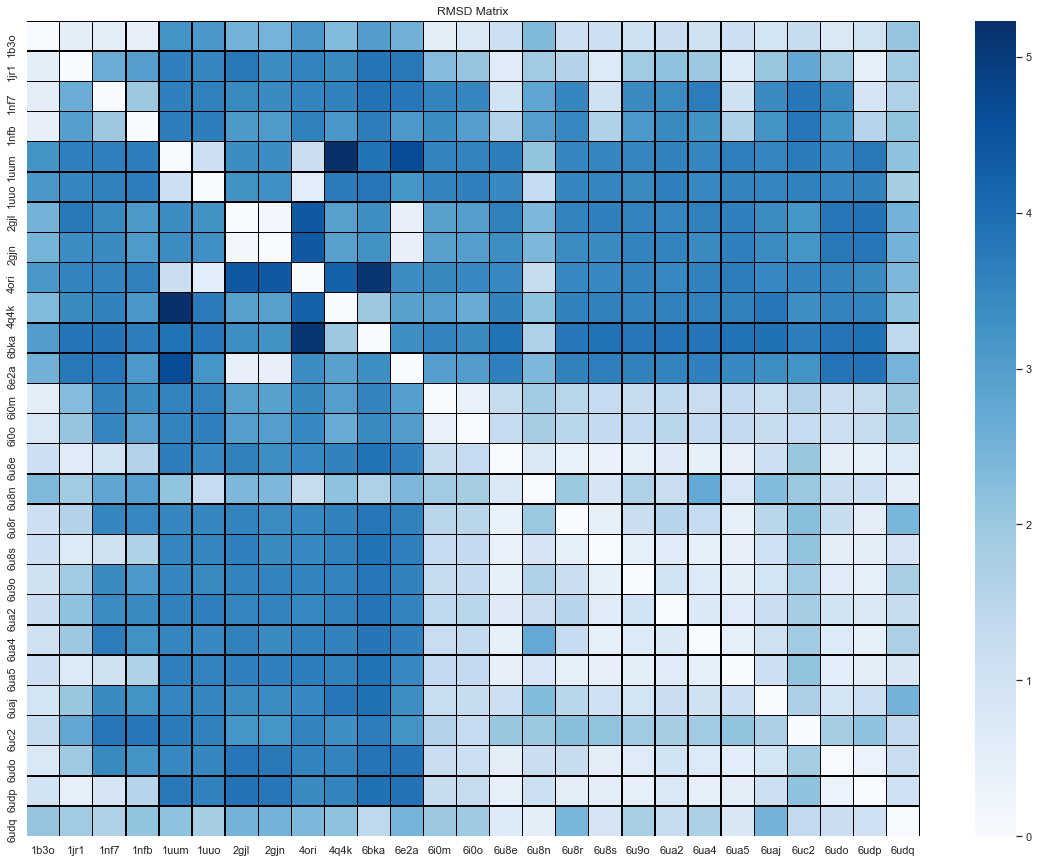

In [11]:
plot_heatmap(csvs_path, rmsd_filename, header='RMSD Matrix')

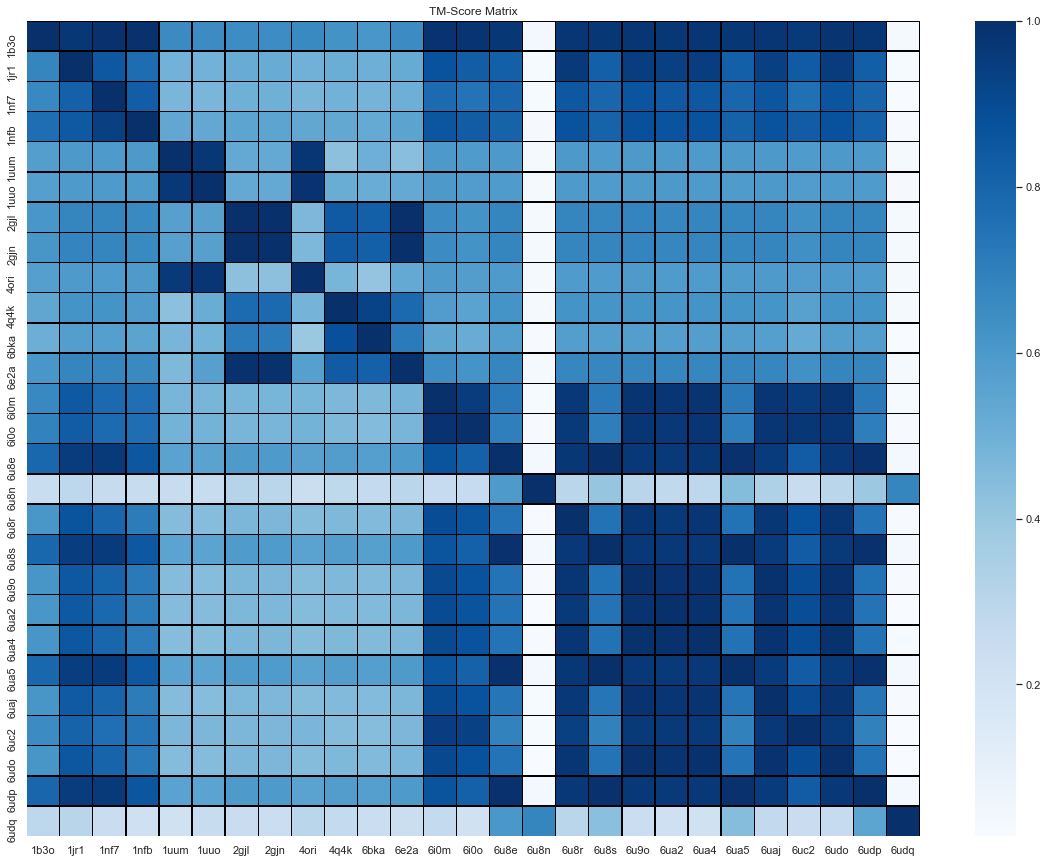

In [12]:
plot_heatmap(csvs_path, tmscore_filename, header='TM-Score Matrix')

## Plot Dendograms

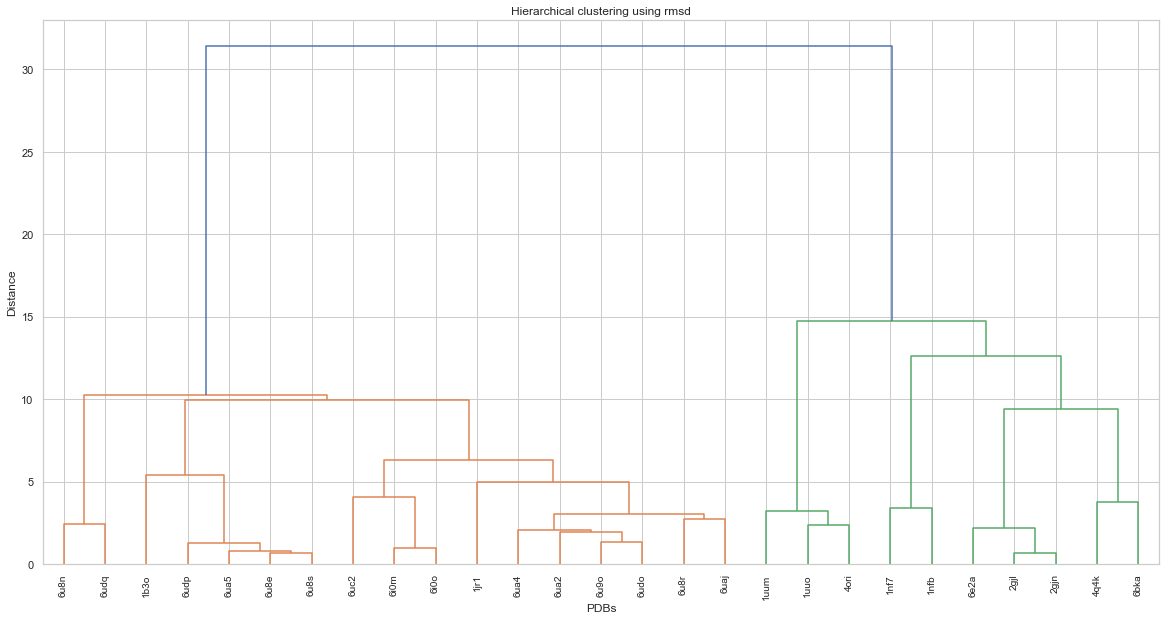

In [13]:
plot_dendogram(rmsdmatrix, header = "Hierarchical clustering using rmsd", save_path = csvs_path + 'dendo_rmsd.png' )

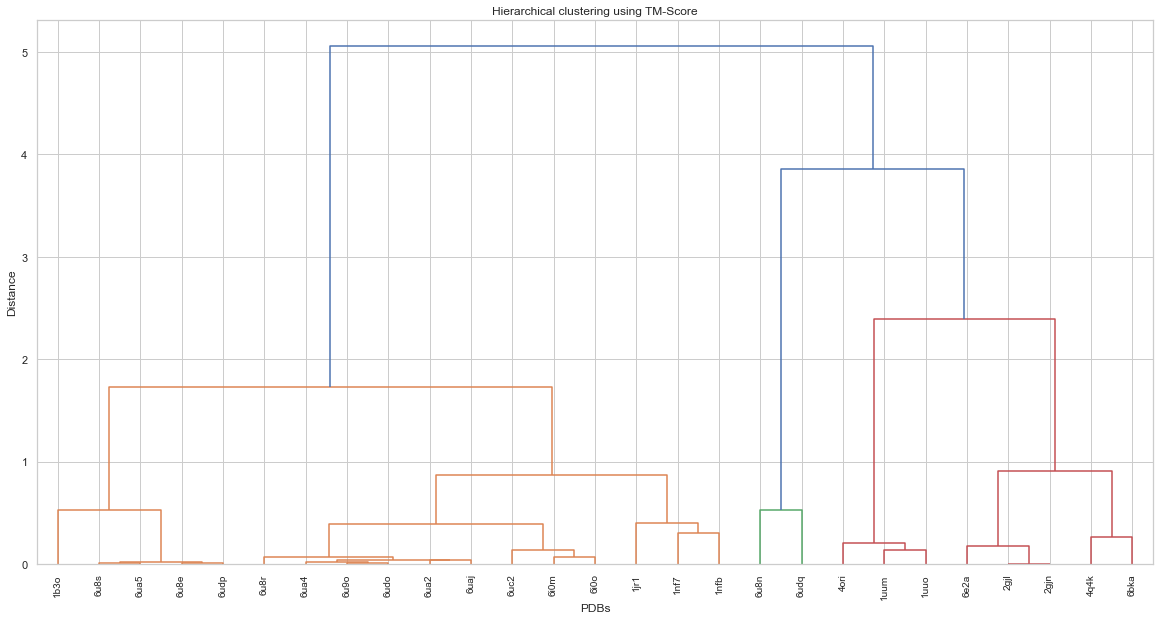

In [14]:
plot_dendogram(tmscorematrix, header = "Hierarchical clustering using TM-Score", save_path = csvs_path + 'dendo_tmscore.png' )

# Remove 2 outliers 
Remove 6u8n and 6udq

In [21]:
rmsdmatrix_2 = rmsdmatrix.drop(['6u8n','6udq'], axis = 0)
rmsdmatrix_2 = rmsdmatrix_2.drop(['6u8n','6udq'], axis = 1)
print(rmsdmatrix_2.shape)
tmscorematrix_2 = tmscorematrix.drop(['6u8n','6udq'], axis = 0)
tmscorematrix_2 = tmscorematrix_2.drop(['6u8n','6udq'], axis = 1)
rmsdmatrix_2.shape

(25, 25)


(25, 25)

In [ ]:
# TODO: replot dendograms and heatmaps

# 5. mTM-Align
We now perform multiple structural alignment on our *family_structures* dataset to identify and visualize conserved positions.

(Check cd-hit_cluster100_mTMalign.fasta file. It contains the multiple structural alignment)

In [ ]:
from Bio.PDB import PDBList, is_aa, PDBIO
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator

from Bio.PDB import PDBList, NeighborSearch
from Bio.PDB.PDBParser import PDBParser
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_distance_matrix(residues, threshold=False, seq_sep=6):

    # Calculate the distance matrix
    distances = []
    for residue1 in residues:
        if residue1.id[0] == " ":  # Exclude hetero/water residues
            row = []
            for residue2 in residues:
                if residue2.id[0] == " ":  # Exclude hetero/water residues
                    if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
                        if threshold: #this way we can compute the distance matrices without 
                            #taking into account the threshold (so to answer question 5 
                            # independentely of question 6)
                            if (residue1["CA"] - residue2["CA"]) <= threshold:
                                row.append(residue1["CA"] - residue2["CA"])
                            else:
                                row.append(None)
                        else:
                            row.append(residue1["CA"] - residue2["CA"])
                    else:
                        row.append(None)
            distances.append(row)

    return np.array(distances, dtype=float)

In [ ]:
path_struct = '.\\data_team_1\\_part_2\\original_datasets\\family_structures\\pdbs_psiblast_C_4_uniref90_1iterations\\cd-hit_clusterings\\superimposed_structure_core.pdb'

structure = PDBParser(QUIET=True).get_structure('core', path_struct)
selected_residues = structure[0]

In [ ]:
sequence_separation = 12
threshold = False
dist_matrix = [get_distance_matrix(residue, threshold, sequence_separation) for residue in selected_residues]
# dist_matrix = get_distance_matrix(selected_residues['A'], threshold, sequence_separation) 

In [ ]:
# plt.figure(figsize = (20,15))
# sns.heatmap(dist_matrix, cmap='Blues')#, linewidths=.01, linecolor="black")

In [ ]:
ncols = 5
nrows = int(np.ceil(len(dist_matrix) / ncols))

plt.figure(figsize = (20,15))
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(3*ncols, 2*nrows))
plt.subplots_adjust(wspace=.05, hspace=.1)

for i, dm in enumerate(dist_matrix):
    sns.heatmap(dist_matrix[i], ax=ax[i//ncols, i%ncols], cmap='Blues')#, linewidths=.01, linecolor="black")

plt.savefig("data_team_1\\_part_2\\original_datasets\\family_structures\\dist_matrices.pdf", bbox_inches='tight')

# 6. Long Range Contacts
In this section we want to visualize which residues are close in the structural sequence alignment but far (more than 12 residues apart) in the sequence.

In [ ]:
sequence_separation = 12
threshold = 8
contact_matrix = [get_distance_matrix(residue, threshold, sequence_separation) for residue in selected_residues]

In [ ]:
contact_matrix = [np.nan_to_num(x, nan = 0) for x in contact_matrix]
avg_contact_matrix = np.mean(contact_matrix, axis=0)

In [ ]:
_ = sns.heatmap(avg_contact_matrix, cmap='Blues')

plt.savefig("data_team_1\\_part_2\\original_datasets\\family_structures\\contact_map.pdf", bbox_inches='tight')

# CATH Superfamily & Family
Download file .tsv file here and place it in the original_dataset folder (I already added it to the .gitignore)
ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_cath_uniprot.tsv.gz

We also use the cath_b.20201021.tsv file to map CATH_ids to CATH superfamilies.

To make this point we will just need to process this .tsv similarly as we did to build our family_structures dataset.

In [ ]:
# all our proteins
print(model_prots)

In [ ]:
uniprot_cath_path = '.\\data_team_1\\_part_2\\original_datasets\\pdb_chain_cath_uniprot.tsv'
uniprot_cath_map = pd.read_csv(uniprot_cath_path, sep = '\t', header=1)
uniprot_cath_map.head()

In [ ]:
cath_superf_path = '.\\data_team_1\\_part_2\\original_datasets\\cath_b.20201021.tsv'
cath_superf_map = pd.read_csv(cath_superf_path, sep = ' ', header=None)
cath_superf_map = cath_superf_map.drop(1, axis=1)
cath_superf_map.columns = ['CATH_ID', 'SUPERF_ID', 'POS (?)']
cath_superf_map.head()

In [ ]:
uniprot_cath_map_model = uniprot_cath_map[uniprot_cath_map.SP_PRIMARY.isin(model_prots)].reset_index()
uniprot_cath_map_model.head()

In [ ]:
model_superfs = cath_superf_map[cath_superf_map.CATH_ID.isin(uniprot_cath_map_model.CATH_ID)].SUPERF_ID
print(model_superfs.values)

In [ ]:
uniprot_cath_map_model['CATH_SUPERFAMILY'] = model_superfs.values
uniprot_cath_map_model.head()

In [ ]:
plt.hist(uniprot_cath_map_model.CATH_SUPERFAMILY)
plt.show()
# http://www.cathdb.info/version/latest/superfamily/3.20.20.70

# Functional Analysis

In [17]:
import gzip
import copy
from Bio import SeqIO, SearchIO
from bd_addons import parse_go_obo
import pandas as pd
import matplotlib.pyplot as plt
from os import path

# Paths of the gene ontology file, All GOAs for the Swissprot databas
go_path = path.join('data_team_1', '_part_2', 'original_datasets', 'go.obo')
goa_path = path.join('data_team_1', '_part_2', 'original_datasets', 'swissprot_goa_all.goa') 
family_sequences_path = path.join('data_team_1', '_part_2', 'original_datasets', 'family_sequences', 'family_seqs_psiblast_C_4_uniref90_1iterations.fasta')

family_sequences = list(SeqIO.parse(family_sequences_path, "fasta"))

In [18]:
# I now parse the whole ontology file
# dictionary with keys: proteins, items: ontology terms associated to the protein
graph = parse_go_obo.parse_obo(go_path)
ancestors, depth, roots = parse_go_obo.get_ancestors(graph)
children = parse_go_obo.get_children(ancestors)

In [19]:
# create the dataframe for the whole Swissprot GOA
goa_db = pd.read_csv(goa_path, sep='\t')
goa_db = goa_db.loc[:,('Entry', 'Gene ontology IDs')]
goa_db.columns = ['uniprot_id', 'go_terms']
goa_db.go_terms =goa_db.go_terms.map(lambda x: x.split("; "))
goa_db['n_go_terms'] = goa_db.go_terms.map(lambda x: len(x))
print('goa_db_shape: {}'.format(goa_db.shape))
goa_db.head()

goa_db_shape: (539890, 3)


,uniprot_id,go_terms,n_go_terms
0,Q6AYX5,"[GO:0000922, GO:0001520, GO:0005737, GO:000581...",18
1,Q6VZZ7,"[GO:0004930, GO:0005502, GO:0005737, GO:000588...",15
2,Q7X9V3,"[GO:0004059, GO:0004468, GO:0005634, GO:000808...",8
3,Q08DS3,"[GO:0000122, GO:0000977, GO:0001655, GO:000165...",44
4,Q9SU24,"[GO:0000278, GO:0000784, GO:0000808, GO:000368...",16


In [20]:
family_sequences_ids = [seq.id[9:] for seq in family_sequences]
print('Number of proteins in our family_sequences database: {}'.format(len(family_sequences_ids)))

Number of proteins in our family_sequences database: 158


In [21]:
# We now take only the proteins that are in our family_sequences 
goa_db_model = goa_db[goa_db.uniprot_id.isin(family_sequences_ids)]
goa_db_model = goa_db_model.reset_index(drop=True)
goa_db_model['n_go_terms'] = goa_db_model.go_terms.map(lambda x: len(x))
print('goa_db_model shape: {}'.format(goa_db_model.shape))
goa_db_model.head()

goa_db_model shape: (158, 3)


,uniprot_id,go_terms,n_go_terms
0,Q74CB9,"[GO:0004152, GO:0004589, GO:0005737, GO:000620...",6
1,B3PIL8,"[GO:0004152, GO:0005737, GO:0005886, GO:000620...",5
2,Q6A912,"[GO:0004152, GO:0004589, GO:0005737, GO:000620...",5
3,Q0BFR0,"[GO:0004152, GO:0005737, GO:0005886, GO:000620...",5
4,B1J5B5,"[GO:0004152, GO:0005737, GO:0005886, GO:000620...",5


In [22]:
# How many repeated/unique, direct annotations in our dataset?
repeated_goas_dataset = pd.Series(goa_db_model.go_terms.sum())
unique_goas_dataset = repeated_goas_dataset.unique()

print('Total number of GOAs: {}'.format(len(repeated_goas_dataset)))
print('Number of unique GOAs: {}'.format(len(unique_goas_dataset)))

Total number of GOAs: 806
Number of unique GOAs: 117


In [23]:
# How many repeated/unique annotations in our dataset, after considering ancestors?
# To see this we create a new dataframe where the go_terms will now include also all the ancestors of all the terms
def include_ancestors(terms_list):
    """
    Given a list of GO terms, returns a list of GO terms where all the ancestors of each term in terms_list is included. NB: the ancestors are added with repetition. """
    terms_list_ancestors = terms_list.copy()
    for term in terms_list:
        if term in ancestors.keys():
            terms_list_ancestors.extend(list(ancestors[term]))
    
    return list(set(terms_list_ancestors))

In [24]:
# Create Database with goas of our model, including ancestors
goa_db_model_anc = goa_db_model.copy()
goa_db_model_anc.go_terms = goa_db_model.go_terms.map(lambda x: include_ancestors(x))
goa_db_model_anc['n_go_terms'] = goa_db_model_anc.go_terms.map(lambda x: len(x))
print("goa_db_model_anc shape: {}".format(goa_db_model_anc.shape))
goa_db_model_anc.head()

goa_db_model_anc shape: (158, 3)


,uniprot_id,go_terms,n_go_terms
0,Q74CB9,"[GO:0009174, GO:0009130, GO:0009156, GO:000620...",71
1,B3PIL8,"[GO:0009174, GO:0009130, GO:0009156, GO:000921...",71
2,Q6A912,"[GO:0009174, GO:0009130, GO:0009156, GO:000620...",71
3,Q0BFR0,"[GO:0009174, GO:0009130, GO:0009156, GO:000921...",71
4,B1J5B5,"[GO:0009174, GO:0009130, GO:0009156, GO:000921...",71


In [25]:
# # How many repeated/unique annotations in our dataset, after considering ancestors?
repeated_goas_dataset_anc = pd.Series(goa_db_model_anc.go_terms.sum())
unique_goas_dataset_anc = repeated_goas_dataset_anc.unique()

print('Total number of GOAs: {}'.format(len(repeated_goas_dataset_anc)))
print('Number of unique GOAs: {}'.format(len(unique_goas_dataset_anc)))

Total number of GOAs: 9756
Number of unique GOAs: 472


To find the enriched terms we have to methods:
- Compute fold increase, and see the terms that have fold increase > 1;
- Compute left and right p-values with fischer exact test and see the ones that have right-p value almost 0 and left p value almost 1;

For both those two methods we will have to build a confusion matrix for each GO term, as defined below.

The fold increase can be then calculated dividing the ratio having-/not-having the property of the selected with the ratio having-/not-having of the not selected.

In [26]:
# Confusion matrix for each term must be like this.
#                 |  Having the property      | Not having the property |
# Selected        |           (1)             |         (2)             |
# --------------- |---------------------------|-------------------------|
# Not selected    |____________(3)____________|__________(4)____________|


# 1 = N. of proteins with GO_i in our dataset;
# 2 = N. of proteins without GO_i in our dataset;
# 3 = N. of proteins with GO_i outside our dataset;
# 4 = N. of proteins without GO_i ourtside our dataset;

# Fold increase = (1/2) / (3/4)

In [27]:
# We create two dictionaries that will keep the count of how many proteins inside, and outside our dataset, have the GO annotation used as key.

proteins_count_dataset_anc = {}  # { term : count } count within our dataset
proteins_count_rest_anc = {}  # { term : count } count outsite our dataset

# convert to dictionary our dataframe so we can iterate on it
df_dict = goa_db.set_index('uniprot_id').to_dict()['go_terms']
for j, (acc, annotations) in enumerate(df_dict.items()):
    # print(acc)
    # print(annotations)
    terms1 = annotations.copy()
    terms = include_ancestors(terms1)

    # now populate the dictionaries
    if acc in family_sequences_ids:
        for term in terms:
            proteins_count_dataset_anc.setdefault(term, 0)
            proteins_count_dataset_anc[term] += 1
    else:
        for term in terms:
            proteins_count_rest_anc.setdefault(term, 0)
            proteins_count_rest_anc[term] += 1

In [28]:
print("Number of unique terms outside dataset, considering ancestors: {}".format(len(proteins_count_rest_anc)))

print("Number of unique terms inside dataset, considering ancestors: {}".format(len(proteins_count_dataset_anc)))


Number of unique terms outside dataset, considering ancestors: 32399
Number of unique terms inside dataset, considering ancestors: 472


In [29]:
# prof solution
data = []
proteins_rest = goa_db.shape[0] - len(family_sequences_ids)

for term in proteins_count_dataset_anc:
    ratio_set = (proteins_count_dataset_anc[term] + 1) / (len(family_sequences_ids) -
        proteins_count_dataset_anc[term] + 1)  # add pseudo count
    ratio_rest = proteins_count_rest_anc.get(term, 1) / (proteins_rest -
        proteins_count_rest_anc.get(term, 0) + 1)  # add pseudo count
    fold_increase = ratio_set / ratio_rest
    data.append((term, fold_increase))

In [30]:
data[:5]

[('GO:0009174', 100.56633812008616),
 ('GO:0009130', 72.81207806679356),
 ('GO:0009156', 78.450096350034),
 ('GO:0006206', 99.28983306783486),
 ('GO:0009218', 65.22934995112415)]

In [31]:
data_filter = [item for item in data if item[1]>1]
data_filter[:5]

[('GO:0009174', 100.56633812008616),
 ('GO:0009130', 72.81207806679356),
 ('GO:0009156', 78.450096350034),
 ('GO:0006206', 99.28983306783486),
 ('GO:0009218', 65.22934995112415)]

In [32]:
print(len(data))
print(len(data_filter))

472
368


In [33]:
enriched_terms = [el[0] for el in data_filter]
print(enriched_terms[:10])

['GO:0009174', 'GO:0009130', 'GO:0009156', 'GO:0006206', 'GO:0009218', 'GO:0019637', 'GO:1901360', 'GO:0009260', 'GO:1901135', 'GO:0006753']


In [34]:
enriched_terms_desc = [graph[enriched_term]['def'] for enriched_term in enriched_terms]

In [35]:
dataset = model_prots

conf_tables = {} # {term : table}
for term in proteins_count_dataset_anc.keys():
    if term in proteins_count_dataset_anc.keys():
        with_goi_dataset = proteins_count_dataset_anc[term]
        without_goi_dataset = len(dataset) - with_goi_dataset
    else:
        with_goi_dataset = 0
        without_goi_dataset  = len(dataset)
    if term in proteins_count_rest_anc.keys():
        with_goi_rest = proteins_count_rest_anc[term]
        without_goi_rest = proteins_rest - with_goi_rest
    else:
        with_goi_rest = 0
        without_goi_rest = proteins_rest

    conf_tables.setdefault(term, [])
    conf_tables[term] = np.array([[with_goi_dataset, without_goi_dataset], [with_goi_rest,without_goi_rest]])

In [36]:
from scipy import stats
pvals = {} # {term : pvalues}
for term in conf_tables:
    conf_table = conf_tables[term]
    _, twosided_p = stats.fisher_exact(conf_table)
    _, left_p = stats.fisher_exact(conf_table, alternative='less')
    _, right_p = stats.fisher_exact(conf_table, alternative='greater')
    pvals.setdefault(term, [])
    pvals[term] = [twosided_p, left_p, right_p]

In [37]:
pvals = pd.DataFrame.from_dict(pvals, columns=['twosided', 'left', 'right'], orient='index').reset_index()
pvals

,index,twosided,left,right
0,GO:0009174,2.736430e-85,1.000000,2.736430e-85
1,GO:0009130,2.331130e-76,1.000000,2.331130e-76
2,GO:0009156,6.846292e-100,1.000000,6.846292e-100
3,GO:0006206,6.187367e-85,1.000000,6.187367e-85
4,GO:0009218,2.469622e-73,1.000000,2.469622e-73
...,...,...,...,...
467,GO:0071310,1.000000e+00,0.586322,6.787707e-01
468,GO:0071345,1.308037e-01,0.974324,1.308037e-01
469,GO:0070670,7.023484e-04,0.999991,7.023484e-04
470,GO:0071353,5.206292e-04,0.999994,5.206292e-04


In [38]:
pvals_index = pvals['index'].to_list()
data_dict = {}

for dat in data:
    data_dict[dat[0]] = dat[1]

ordered_data = []

for ind in pvals_index:
    ordered_data.append(data_dict[ind])
    
pvals['fold_increase'] = ordered_data

[('GO:0004152', 814.4575640765538),
 ('GO:0016491', 41.874249249249246),
 ('GO:0006793', 14.569623542632392),
 ('GO:0072528', 39.01855169017275),
 ('GO:0006221', 47.113239867353975)]

In [39]:
pvals_sorted = pvals.sort_values(by=['fold_increase'], ascending=False).reset_index(drop=True)

,index,twosided,left,right,fold_increase
0,GO:0018580,7.644800e-39,1.000000,7.644800e-39,5175.426027
1,GO:0050040,1.232934e-03,0.999999,1.232934e-03,3416.018987
2,GO:0004589,5.751475e-75,1.000000,5.751475e-75,1804.896321
3,GO:0003938,1.948743e-69,1.000000,1.948743e-69,1708.576210
4,GO:0016703,1.554491e-34,1.000000,1.554491e-34,1094.689655
5,GO:0004152,5.689520e-143,1.000000,5.689520e-143,814.457564
6,GO:0016635,8.598526e-137,1.000000,8.598526e-137,647.346075
7,GO:1990663,2.512111e-09,1.000000,2.512111e-09,483.599462
8,GO:0019516,9.670195e-34,1.000000,9.670195e-34,458.195854
9,GO:0008891,7.374939e-03,0.999974,7.374939e-03,401.873418


In [40]:
n_children = {}

for i, (k, v) in enumerate(children.items()):
    if k in pvals_index:
        n_children[k] = len(v)

pvals_sorted['n_children'] = pvals_sorted['index'].apply(lambda x: n_children[x] if x in list(n_children.keys()) else 0)

,index,twosided,left,right,fold_increase,n_children
0,GO:0018580,7.644800e-39,1.000000e+00,7.644800e-39,5175.426027,0
1,GO:0050040,1.232934e-03,9.999995e-01,1.232934e-03,3416.018987,0
2,GO:0004589,5.751475e-75,1.000000e+00,5.751475e-75,1804.896321,0
3,GO:0003938,1.948743e-69,1.000000e+00,1.948743e-69,1708.576210,0
4,GO:0016703,1.554491e-34,1.000000e+00,1.554491e-34,1094.689655,24
...,...,...,...,...,...,...
467,GO:0032555,9.647646e-18,6.613475e-18,1.000000e+00,0.081394,24
468,GO:0017076,9.576680e-18,4.793886e-18,1.000000e+00,0.080748,37
469,GO:0016021,4.752901e-14,2.114556e-14,1.000000e+00,0.073760,57
470,GO:0031224,1.758305e-14,1.064424e-14,1.000000e+00,0.072187,132


In [41]:
descriptions = {}

for i, (k, v) in enumerate(graph.items()):
    if k in pvals_index:
        descriptions[k] = v['def']

pvals_sorted['description'] = pvals_sorted['index'].apply(lambda x: descriptions[x] if x in list(descriptions.keys()) else '')

,index,twosided,left,right,fold_increase,n_children,description
0,GO:0018580,7.644800e-39,1.000000e+00,7.644800e-39,5175.426027,0,nitronate monooxygenase activity
1,GO:0050040,1.232934e-03,9.999995e-01,1.232934e-03,3416.018987,0,lactate 2-monooxygenase activity
2,GO:0004589,5.751475e-75,1.000000e+00,5.751475e-75,1804.896321,0,orotate reductase (NADH) activity
3,GO:0003938,1.948743e-69,1.000000e+00,1.948743e-69,1708.576210,0,IMP dehydrogenase activity
4,GO:0016703,1.554491e-34,1.000000e+00,1.554491e-34,1094.689655,24,"oxidoreductase activity, acting on single dono..."
...,...,...,...,...,...,...,...
467,GO:0032555,9.647646e-18,6.613475e-18,1.000000e+00,0.081394,24,purine ribonucleotide binding
468,GO:0017076,9.576680e-18,4.793886e-18,1.000000e+00,0.080748,37,purine nucleotide binding
469,GO:0016021,4.752901e-14,2.114556e-14,1.000000e+00,0.073760,57,integral component of membrane
470,GO:0031224,1.758305e-14,1.064424e-14,1.000000e+00,0.072187,132,intrinsic component of membrane


In [42]:
pvals_sorted.sort_values(by=['fold_increase'], ascending=False).head(20)

,index,twosided,left,right,fold_increase,n_children,description
0,GO:0018580,7.644800e-39,1.000000,7.644800e-39,5175.426027,0,nitronate monooxygenase activity
1,GO:0050040,1.232934e-03,0.999999,1.232934e-03,3416.018987,0,lactate 2-monooxygenase activity
2,GO:0004589,5.751475e-75,1.000000,5.751475e-75,1804.896321,0,orotate reductase (NADH) activity
3,GO:0003938,1.948743e-69,1.000000,1.948743e-69,1708.576210,0,IMP dehydrogenase activity
4,GO:0016703,1.554491e-34,1.000000,1.554491e-34,1094.689655,24,"oxidoreductase activity, acting on single dono..."
5,GO:0004152,5.689520e-143,1.000000,5.689520e-143,814.457564,2,dihydroorotate dehydrogenase activity
6,GO:0016635,8.598526e-137,1.000000,8.598526e-137,647.346075,8,"oxidoreductase activity, acting on the CH-CH g..."
7,GO:1990663,2.512111e-09,1.000000,2.512111e-09,483.599462,0,dihydroorotate dehydrogenase (fumarate) activity
8,GO:0019516,9.670195e-34,1.000000,9.670195e-34,458.195854,0,lactate oxidation
9,GO:0008891,7.374939e-03,0.999974,7.374939e-03,401.873418,0,glycolate oxidase activity


In [60]:
dict_sub_tree = {}

for term in pvals_index:
    if graph[term]["namespace"] == "biological_process":
        dict_sub_tree.setdefault(graph[term]["namespace"], []).append(graph[term]["def"])
    elif graph[term]["namespace"] == "cellular_component":
        dict_sub_tree.setdefault(graph[term]["namespace"], []).append(graph[term]["def"])
    else:
        dict_sub_tree.setdefault(graph[term]["namespace"], []).append(graph[term]["def"])

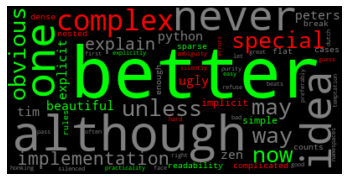

In [61]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

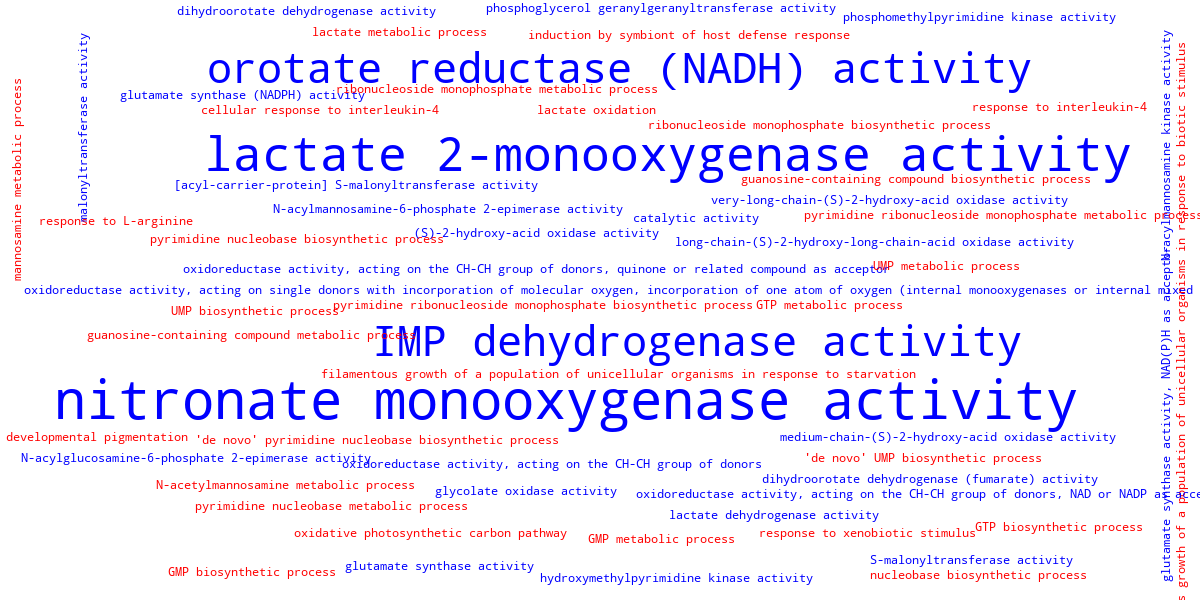

In [74]:
wc = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    mode="RGBA",
    color_func = lambda *args, **kwargs: (18,10,143),
    max_words = 100,
    scale = 3,
    collocations=False
)

frequencies = np.sqrt(pvals_sorted.set_index('description').fold_increase)
wc.generate_from_frequencies(frequencies)

color_to_words = {
    'red': dict_sub_tree['biological_process'],
    'green': dict_sub_tree['cellular_component'],
    'blue': dict_sub_tree['molecular_function']
}

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey' 

# Create a color function with single tone
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

path_wc = path.join('data_team_1', '_part_2', 'functional_analysis', 'wc.png')
wc.to_file(path_wc)
wc.to_image()